In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [33]:
mi_df =  pd.read_csv(
    'data/01_data_cruda/MI_data.csv', 
    header=0, 
    sep=","
)

There  are  four  possible  time  moments  for  complication  prediction:  on  base  of  the information known at

1.the time of admission to hospital:all input columns (2-112) except 93, 94, 95, 100, 101, 102, 103, 104, 105can be usedfor prediction;

2.the end of the first day(24 hours after admission to the hospital):all input columns (2-112) except 94, 95, 101, 102, 104, 105 can be usedfor prediction;

3.the end of the second day (48 hours after admission to the hospital) all input columns (2-112) except 95, 102, 105 can be usedfor prediction;

4.the end of the third day (72 hours after admission to the hospital) all input columns (2-112) can be usedfor prediction.

---




In [34]:
len(mi_df.columns.tolist())

124

In [3]:
# Hacemos referencia a las columnas 2-112 (Variables que pueden ser usadas para la predicción)

# Referenciamos columnas con indice de 0 a 111
var_objetivo_lst = [
    'FIBR_PREDS','PREDS_TAH','JELUD_TAH','FIBR_JELUD',
    'A_V_BLOK','OTEK_LANC','RAZRIV','DRESSLER','ZSN',
    'REC_IM','P_IM_STEN'
    #,'LET_IS'
]
mi_objetivo_df = mi_df[var_objetivo_lst]
mi_predictoras_df = mi_df.iloc[:,0:112]

mi_df = pd.concat([mi_predictoras_df, mi_objetivo_df], axis=1, join='inner')
# Removemos columnas 93, 94 , 95, 101, 102, 103, 104, 105
mi_df.drop(mi_df.columns[[1-1, 93-1, 94-1 , 95-1, 101-1, 102-1, 103-1, 104-1, 105-1]],axis = 1, inplace=True)

### 1. Removemos columnas

#### 1.1 Remover columnas que tienen un porcentaje de valores únicos superior al 70%

In [4]:
#Determinamos aquellas columnas (variables) que tengan un porcentaje de filas (registros) únicas por cada columna (variable) mayor al valor de 0.7
threshold = 0.7

unique_percentages = mi_df.nunique() / len(mi_df)

criteria = unique_percentages > threshold

columns_to_filter = unique_percentages[criteria].keys()

#Eliminamos las columnas (variables) seleccionadas en el paso anterior. Al aplicar "drop" obtenemos un nuevo "DataFrame", pero con el parámetro
#inplace igual a "True" podemos realizar dicha operación de eliminación y sobre-escribir el "DataFrame" del cual estamos eliminando con el
#nuevo "DataFrame" obtenido. El parámetro axis permite seleccionar el eje respecto al cual aplicar la operación "drop". Los valores válidos
#son [0 o "index"] y [1 o "columns"]
mi_df.drop(columns_to_filter, axis=1, inplace=True)

### 2. Tratamiento de datos perdidos

In [5]:
from collections import defaultdict
from sklearn import preprocessing 

In [6]:
### El dataset solo contiene variables numéricas y no contiene variables categóricas que tengan que ser codificadas

# Agrupando columnas por tipo de datos
tipos = mi_df.columns.to_series().groupby(mi_df.dtypes).groups

# Armando lista de columnas categóricas
cint = tipos[np.dtype('int64')]
# Armando lista de columnas numéricas
cfloat = tipos[np.dtype("float64")]

In [7]:
## Para columnas que tengan > 20% de valores perdidos: Eliminar
cols_mayor_a_20 = [col for col in mi_df.columns if ((mi_df[col].isnull().sum() / len(mi_df)*100) > 20.0)]

mi_df.drop(
    cols_mayor_a_20, 
    axis = 1, 
    inplace=True
)

In [8]:
## Para columnas que tengan entre 15% y 20% de valores perdidos: Imputar con modelos
cols_entre_15_y_20 = [
    col for col in mi_df.columns if 
        (((mi_df[col].isnull().sum() / len(mi_df)*100))>=15 and  
        ((mi_df[col].isnull().sum() / len(mi_df)*100))<=20)
]

In [9]:
mi_imp_wt_model_df = mi_df.copy() 
mi_imp_wt_model_df.drop(
    var_objetivo_lst,
    axis = 1, 
    inplace=True
)

es_null=pd.isna(mi_imp_wt_model_df.loc[:, 'S_AD_ORIT'])
#Selecciona solo los que contiene "True"
df_m_null = mi_imp_wt_model_df.loc[es_null]
#df_m_null.info()

In [10]:
mi_df["AST_BLOOD"].unique()

array([ nan, 0.18, 0.11, 0.37, 0.22, 0.45, 0.6 , 0.15, 0.07, 0.38, 0.3 ,
       0.26, 0.44, 0.41, 0.52, 0.5 , 0.33, 0.04, 0.67, 0.75, 0.2 , 1.34,
       0.4 , 1.12, 0.86, 0.48, 0.96, 1.04, 0.63, 0.14, 0.13, 0.08, 1.2 ,
       0.36, 0.9 , 0.82, 0.56, 0.12, 0.57, 0.66, 1.13, 2.15, 0.27, 0.8 ,
       0.46, 0.74, 0.23, 0.1 , 0.7 , 1.05, 0.28, 0.68, 0.98, 1.36, 0.71,
       1.75, 0.97, 1.08, 0.49])

In [11]:
for col in cols_entre_15_y_20:
    mode = mi_df[col].mode()[0]
    print(mode)
    mi_df[col].fillna(mode, inplace=True) 

130.0
80.0
0.15
0.15


In [12]:
## Para columnas que tengan menos de 15% de valores perdidos: Imputar con Media, Moda y Mediana
cols_menor_a_15 = [col for col in mi_df.columns if ((mi_df[col].isnull().sum() / len(mi_df)*100) < 15.0)]

Notas de la libreria SimpleImputer para el parametro "strategy"

- Si es "mean", reemplace los valores faltantes usando la media a lo largo de cada columna. Solo se puede usar con datos numéricos flotantes (float).

- Si es "median", reemplace los valores faltantes usando la mediana a lo largo de cada columna. Solo se puede usar con datos numéricos enteros (int).

- Si es "most_frequent", reemplace falta utilizando el valor más frecuente a lo largo de cada columna. Se puede usar con cadenas o datos numéricos que representan variables categóricas (str/int).

In [13]:
imp_media = SimpleImputer(missing_values=np.nan, #etiqueta de valores nulos
                    strategy='mean') #método o estrategia de imputación
#imp_media es la función con los parámetros ya especificados de nuestra función

imp_moda = SimpleImputer(missing_values=np.nan, #etiqueta de valores nulos
                    strategy='most_frequent') #método o estrategia de imputación
#imp_moda es la función con los parámetros ya especificados de nuestra función

In [14]:
missing_cols_int_lst = [col for col in cols_menor_a_15 if col in cint]

mi_int_limpio_df = imp_moda.fit_transform(mi_df[missing_cols_int_lst])
mi_int_limpio_df = pd.DataFrame(mi_int_limpio_df, columns=missing_cols_int_lst)

In [15]:
missing_cols_float_lst = [col for col in cols_menor_a_15 if col in cfloat]

mi_float_limpio_df = imp_media.fit_transform(mi_df[missing_cols_float_lst])
mi_float_limpio_df = pd.DataFrame(mi_float_limpio_df, columns=missing_cols_float_lst)

In [16]:
mi_df.drop(
    missing_cols_int_lst+missing_cols_float_lst,
    axis = 1, 
    inplace=True
)
mi_df = pd.concat([mi_df, mi_int_limpio_df],    axis=1, join='inner')
mi_df = pd.concat([mi_df, mi_float_limpio_df],  axis=1, join='inner')

In [32]:
len(mi_df[columns_lst].columns.tolist())

92

## 3. Distribución de muestras del conjunto de datos

In [17]:
columns_lst = mi_df.columns.tolist()
columns_lst = [x for x in columns_lst if (x not in var_objetivo_lst)]
# columns_lst.remove("COMPLICATION_OUT")

X=mi_df[columns_lst]
y=mi_df[var_objetivo_lst]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.20, # 20% de pruebas y 70% de entrenamiento
                     random_state=2022)

y_train=pd.DataFrame(y_train,columns=var_objetivo_lst)
y_test=pd.DataFrame(y_test,columns=var_objetivo_lst)

In [18]:
### Separación de Datasets por variable objetivo

X_TRAIN_DICT = dict()
X_TEST_DICT  = dict()
Y_TRAIN_DICT = dict()
Y_TEST_DICT  = dict()
for var_objetivo in var_objetivo_lst:
    print(var_objetivo)
    X_TRAIN_DICT[var_objetivo] = pd.DataFrame(X_train[columns_lst],columns=columns_lst)
    X_TEST_DICT[var_objetivo]  = pd.DataFrame(X_test[columns_lst],columns=columns_lst)
    Y_TRAIN_DICT[var_objetivo] = pd.DataFrame(y_train[var_objetivo],columns=[var_objetivo])
    Y_TEST_DICT[var_objetivo]  = pd.DataFrame(y_test[var_objetivo],columns=[var_objetivo])

FIBR_PREDS
PREDS_TAH
JELUD_TAH
FIBR_JELUD
A_V_BLOK
OTEK_LANC
RAZRIV
DRESSLER
ZSN
REC_IM
P_IM_STEN


## 4. Escalamiento de los datos

- Realizamos Normalización de los datos

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler() #estamos guardando la función en el objeto mms


x_train_morm = mms.fit_transform(X_train)#entrenamiento
#fit_transform()- aplicar la función y aprender de los datos de entrenamiento

X_test_norm = mms.transform(X_test)#testeo
#transform() - los parámetros de los datos de entrenamiento los aplica a los de testeo
#con el objetivo trazado por la función (en nuestro caso estandarizar datos)

X_train=pd.DataFrame(x_train_morm,columns=X_train.columns.tolist())
X_test=pd.DataFrame(X_test_norm,columns=X_test.columns.tolist())

for var_objetivo in var_objetivo_lst:
    X_TRAIN_DICT[var_objetivo] = X_train
    X_TEST_DICT[var_objetivo] = X_test

---

## 5. Balanceo de datos

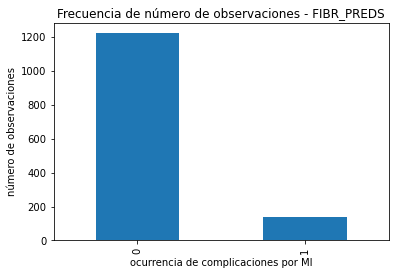

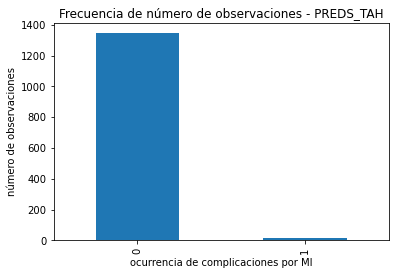

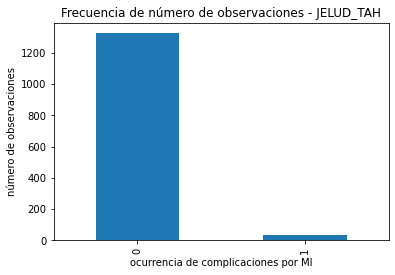

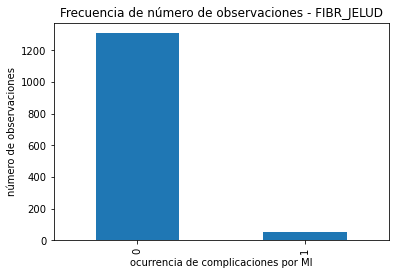

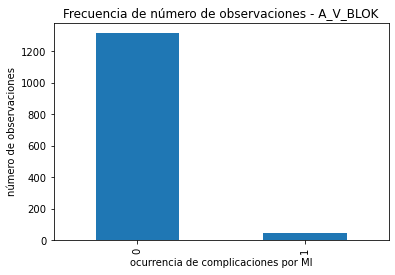

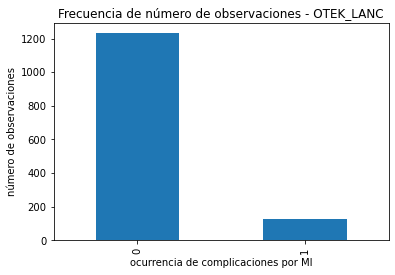

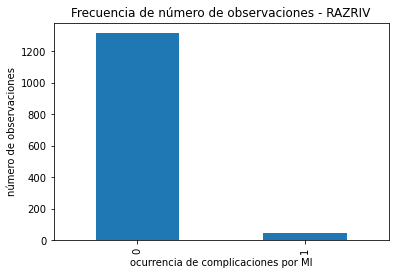

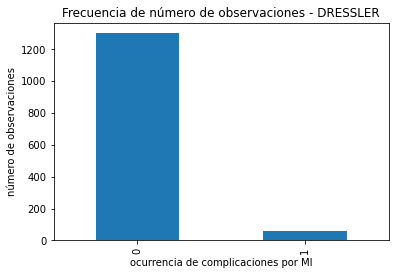

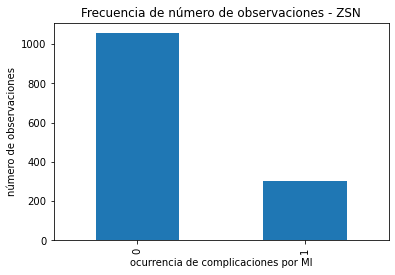

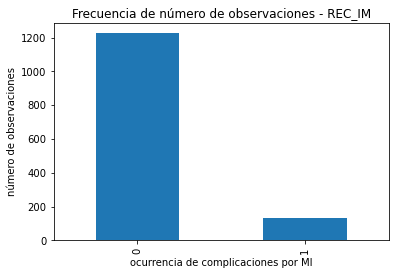

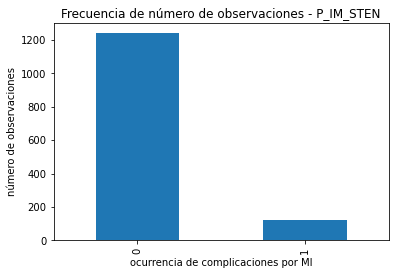

In [20]:
for var_objetivo in var_objetivo_lst:
    y_train_graph = Y_TRAIN_DICT[var_objetivo].squeeze()
    count_classes = pd.value_counts(y_train_graph, sort = True)

    count_classes.plot(kind = 'bar', #bar: gráfico de barras
                       rot=90)#0 = no rotación de las etiquetas del eje x
    plt.xticks(range(2))
    plt.title(f"Frecuencia de número de observaciones - {var_objetivo}")
    plt.xlabel("ocurrencia de complicaciones por MI")
    plt.ylabel("número de observaciones")
    plt.show()

- Como se puede apreciar en las gráficas anteriores, las variables objetivo están desbalanceadas. Por tal motivo, se realizará un balanceo de datos.

In [21]:
from imblearn.combine import SMOTETomek

for var_objetivo in var_objetivo_lst:
    y_train = Y_TRAIN_DICT[var_objetivo]
    X_train = X_TRAIN_DICT[var_objetivo]
    
    os_us = SMOTETomek(0.98)

    X_t_st, y_t_st = os_us.fit_resample(X_train, y_train)
    #Datos de entrenamiento
    x_t_smotetomek= pd.DataFrame(X_t_st, columns=X_train.columns.tolist())
    y_t_smotetomek= pd.DataFrame(y_t_st, columns=[var_objetivo])

    X_TRAIN_DICT[var_objetivo] = x_t_smotetomek
    Y_TRAIN_DICT[var_objetivo] = y_t_smotetomek
    x_t_smotetomek.head()

D:\Users\coliverac\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:586: FutureWarning: Pass sampling_strategy=0.98 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
D:\Users\coliverac\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:586: FutureWarning: Pass sampling_strategy=0.98 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
D:\Users\coliverac\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:586: FutureWarning: Pass sampling_strategy=0.98 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
D:\Users\coliverac\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:586: FutureWarning: Pass sampling_strategy=0.98 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
D:\Users\coliverac\Anaconda3\lib\site-packages\i

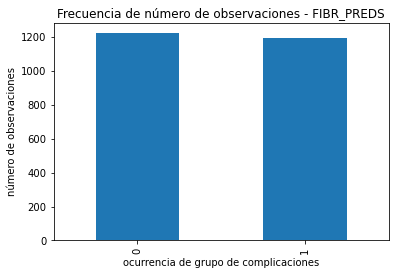

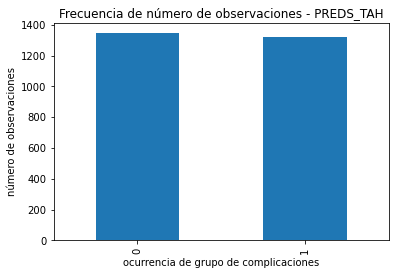

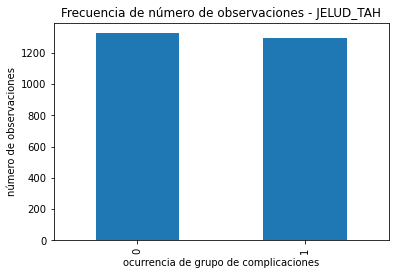

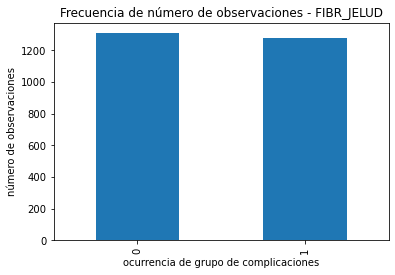

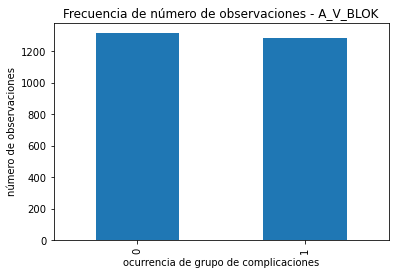

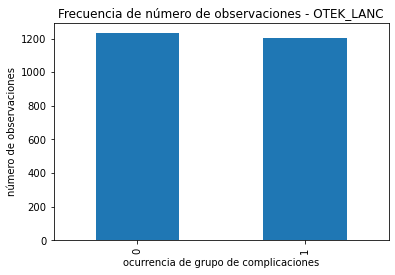

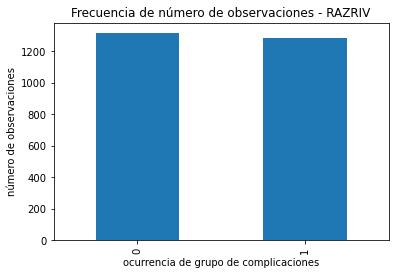

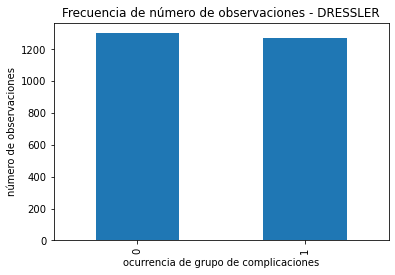

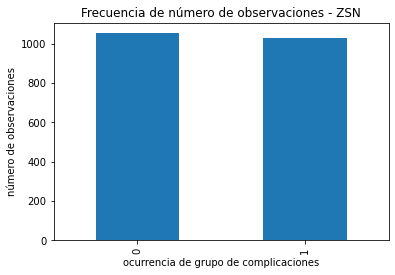

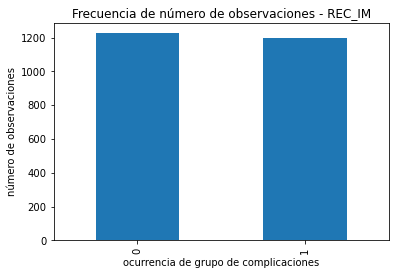

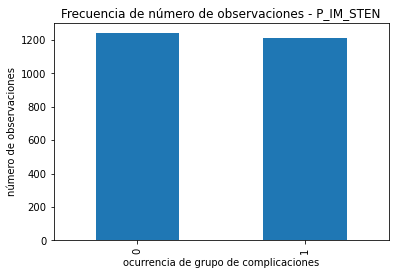

In [22]:
for var_objetivo in var_objetivo_lst:
    y_train = Y_TRAIN_DICT[var_objetivo].squeeze()
    count_classes = pd.value_counts(y_train, sort = True)

    count_classes.plot(kind = 'bar', #bar: gráfico de barras
                       rot=90)#0 = no rotación de las etiquetas del eje x
    plt.xticks(range(2))
    plt.title(f"Frecuencia de número de observaciones - {var_objetivo}")
    plt.xlabel("ocurrencia de grupo de complicaciones")
    plt.ylabel("número de observaciones")
    plt.show()

---

In [23]:
X_TRAIN_PREPROCESADO = pd.DataFrame()
X_TEST_PREPROCESADO  = pd.DataFrame()
Y_TRAIN_PREPROCESADO = pd.DataFrame()
Y_TEST_PREPROCESADO  = pd.DataFrame()
for var_objetivo in var_objetivo_lst:
    X_train = X_TRAIN_DICT[var_objetivo]
    X_test  = X_TEST_DICT[var_objetivo]
    y_train = Y_TRAIN_DICT[var_objetivo]
    y_test  = Y_TEST_DICT[var_objetivo]
    X_train["var_objetivo"] = var_objetivo
    X_test["var_objetivo"]  = var_objetivo
    y_train["var_objetivo"] = var_objetivo
    y_test["var_objetivo"]  = var_objetivo
    
    
    X_TRAIN_PREPROCESADO = pd.concat([X_TRAIN_PREPROCESADO,X_train], axis=0)
    X_TEST_PREPROCESADO  = pd.concat([X_TEST_PREPROCESADO,X_test], axis=0)
    Y_TRAIN_PREPROCESADO = pd.concat([Y_TRAIN_PREPROCESADO,y_train], axis=0)
    Y_TEST_PREPROCESADO  = pd.concat([Y_TEST_PREPROCESADO,y_test], axis=0)

In [24]:
for var_objetivo in var_objetivo_lst:
    
    var1  = Y_TEST_PREPROCESADO.loc[Y_TEST_PREPROCESADO["var_objetivo"]==var_objetivo]
    
    print("*"*100)
    print(var_objetivo)
    print("-"*100)
    print((var1.isnull().sum() / len(var1)*100))

****************************************************************************************************
FIBR_PREDS
----------------------------------------------------------------------------------------------------
FIBR_PREDS        0.0
var_objetivo      0.0
PREDS_TAH       100.0
JELUD_TAH       100.0
FIBR_JELUD      100.0
A_V_BLOK        100.0
OTEK_LANC       100.0
RAZRIV          100.0
DRESSLER        100.0
ZSN             100.0
REC_IM          100.0
P_IM_STEN       100.0
dtype: float64
****************************************************************************************************
PREDS_TAH
----------------------------------------------------------------------------------------------------
FIBR_PREDS      100.0
var_objetivo      0.0
PREDS_TAH         0.0
JELUD_TAH       100.0
FIBR_JELUD      100.0
A_V_BLOK        100.0
OTEK_LANC       100.0
RAZRIV          100.0
DRESSLER        100.0
ZSN             100.0
REC_IM          100.0
P_IM_STEN       100.0
dtype: float64
*****************

In [25]:
for var_objetivo in var_objetivo_lst:
    
    X_TRAIN_PREPROCESADO.to_csv(f'data/02_data_intermedia/X_MI_entrenamiento_preprocesado.csv',index=False)
    X_TEST_PREPROCESADO.to_csv(f'data/02_data_intermedia/X_MI_pruebas_preprocesado.csv',index=False)

    Y_TRAIN_PREPROCESADO.to_csv(f'data/02_data_intermedia/y_MI_entrenamiento_preprocesado.csv',index=False)
    Y_TEST_PREPROCESADO.to_csv(f'data/02_data_intermedia/y_MI_pruebas_preprocesado.csv',index=False)

In [26]:
for var_objetivo in var_objetivo_lst:
    
    X_train = X_TRAIN_DICT[var_objetivo]
    X_test  = X_TEST_DICT[var_objetivo]
    print("*"*100)
    print(var_objetivo)
    print("-"*100)
    print((X_train.isnull().sum() / len(X_train)*100))
    print((X_test.isnull().sum() / len(X_test)*100))
    print("*"*100)

****************************************************************************************************
FIBR_PREDS
----------------------------------------------------------------------------------------------------
SEX             0.0
AGE             0.0
INF_ANAM        0.0
STENOK_AN       0.0
FK_STENOK       0.0
               ... 
GEPAR_S_n       0.0
ASP_S_n         0.0
TIKL_S_n        0.0
TRENT_S_n       0.0
var_objetivo    0.0
Length: 93, dtype: float64
SEX             0.0
AGE             0.0
INF_ANAM        0.0
STENOK_AN       0.0
FK_STENOK       0.0
               ... 
GEPAR_S_n       0.0
ASP_S_n         0.0
TIKL_S_n        0.0
TRENT_S_n       0.0
var_objetivo    0.0
Length: 93, dtype: float64
****************************************************************************************************
****************************************************************************************************
PREDS_TAH
---------------------------------------------------------------------------------

In [27]:
for var_objetivo in var_objetivo_lst:
    
    y_test  = Y_TEST_DICT[var_objetivo]
    
    print("*"*100)
    print(var_objetivo)
    print("-"*100)
    print((y_test.isnull().sum() / len(y_test)*100))

****************************************************************************************************
FIBR_PREDS
----------------------------------------------------------------------------------------------------
FIBR_PREDS      0.0
var_objetivo    0.0
dtype: float64
****************************************************************************************************
PREDS_TAH
----------------------------------------------------------------------------------------------------
PREDS_TAH       0.0
var_objetivo    0.0
dtype: float64
****************************************************************************************************
JELUD_TAH
----------------------------------------------------------------------------------------------------
JELUD_TAH       0.0
var_objetivo    0.0
dtype: float64
****************************************************************************************************
FIBR_JELUD
--------------------------------------------------------------------------------------